In [1]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
address = "https://raw.githubusercontent.com/Jaeik-Jeong/RLES/main/"

data_price = pd.read_csv(address+'price.csv', index_col=0)
data_train_csv = pd.DataFrame(data_price['Price'][:1000])
data_val_csv   = pd.DataFrame(data_price['Price'][1000:1500])
data_test_csv  = pd.DataFrame(data_price['Price'][1500:2000])

In [3]:
# Data Preprocessing

Battery_Size = 1 #p.u.

max_price = max(data_price['Price'])

size_train0 = len(data_train_csv)
size_val0   = len(data_val_csv)
size_test0  = len(data_test_csv)

price_train = list(data_train_csv['Price']/max_price)
price_val = list(data_val_csv['Price']/max_price)
price_test = list(data_test_csv['Price']/max_price)

In [4]:
# Agent

n_layers         = 2
in_size          = 2
hidden_size      = 64
out_size         = 1
T_horizon        = 128
learning_rate    = 0.001
K_epoch          = 3
gamma            = 0.99
lmbda            = 0.95
eps_clip         = 0.1
C_value          = 1
var              = 0.1**2

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.fc_s  = nn.Linear(in_size, hidden_size)
        self.rnn   = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.fc_pi = nn.Linear(hidden_size, out_size)
        self.fc_v  = nn.Linear(hidden_size, 1)

    def pi(self, x, hidden):
        x = F.relu(self.fc_s(x))
        x = x.view(1, -1, hidden_size)
        x, hidden = self.rnn(x, hidden)
        pi = self.fc_pi(x)
        pi = pi.view(-1, out_size)
        return pi, hidden

    def v(self, x, hidden):
        x = F.relu(self.fc_s(x))
        x = x.view(1, -1, hidden_size)
        x, hidden = self.rnn(x, hidden)
        v = self.fc_v(x)
        v = v.view(-1, 1)
        return v

buffer_limit  = 50000
batch_size    = 32
epsilon       = 0.1
out_size2     = 3

class LSTM2(nn.Module):
    def __init__(self):
        super(LSTM2, self).__init__()
        self.fc_in  = nn.Linear(in_size, hidden_size)
        self.rnn   = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, out_size2)

    def forward(self, x, hidden):
        x = F.relu(self.fc_in(x))
        x = x.view(1, -1, hidden_size)
        x, hidden = self.rnn(x, hidden)
        x = self.fc_out(x)
        x = x.view(-1, out_size2)
        return x, hidden

    def sample_action(self, x, hidden, epsilon):
        out, hidden = self.forward(x, hidden)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,2), hidden
        else :
            return out.argmax().item(), hidden

In [5]:
# Environment

E_max   = Battery_Size
P_max   = E_max
tdelta  = 0.5
soc_min = 0.1
soc_max = 0.9
a0 = -1.031; a1 = 35; a2 = 3.685; a3 = 0.2156; a4 = 0.1178; a5 = 0.3201
b0 = 0.1463; b1 = 30.27; b2 = 0.1037; b3 = 0.0584; b4 = 0.1747; b5 = 0.1288
c0 = 0.1063; c1 = 62.49; c2 = 0.0437; d0 = 0.0712; d1 = 61.4; d2 = 0.0288
N = 130*215*E_max/0.1
beta = 1/max_price

class Env():
    def __init__(self, L, data):
        self.data_imb = data
        self.lagrange = L
        self.state = []

    def reset(self):
        imb = self.data_imb[0]
        E = E_max/2
        state = [[imb, E]]
        self.state = state
        return state

    def step(self, action):
        imb = self.data_imb[len(self.state)]

        E = self.state[-1][-1]
        soc = E/E_max
        Voc = a0*np.exp(-a1*soc) + a2 + a3*soc - a4*soc**2 + a5*soc**3
        Rs  = b0*np.exp(-b1*soc) + b2 + b3*soc - b4*soc**2 + b5*soc**3
        Rts = c0*np.exp(-c1*soc) + c2
        Rtl = d0*np.exp(-d1*soc) + d2
        R   = Rs + Rts + Rtl

        I_cmax = 1000000*(E_max*soc_max - E)/N/(Voc*tdelta)
        I_dmax = 1000000*(E - E_max*soc_min)/N/(Voc*tdelta)
        p_cmax = N*(Voc*I_cmax + I_cmax**2*R)
        p_dmax = N*(Voc*I_dmax - I_dmax**2*R)

        P_cmax = p_cmax/1000000; P_dmax = p_dmax/1000000
        P_c = min(max(-action[0]*E_max, 0), P_max, P_cmax)
        P_d = min(max(action[0]*E_max,  0), P_max, P_dmax)
        p_c = 1000000*P_c/N; p_d = 1000000*P_d/N

        I_c = -(Voc - np.sqrt(Voc**2 + 4*R*p_c))/(2*R)
        I_d = (Voc - np.sqrt(Voc**2 - 4*R*p_d))/(2*R)
        if not np.isclose(p_c, 0):
            eff_c = (Voc*I_c)/p_c; eff_d = 1
            E_prime = E + eff_c*P_c*tdelta
            disp = -P_c
        elif not np.isclose(p_d, 0):
            eff_d = p_d/(Voc*I_d); eff_c = 1
            E_prime = E - (1/eff_d)*P_d*tdelta
            disp = P_d
        else:
            eff_c = 1; eff_d = 1
            E_prime = E
            disp = 0

        revenue = (imb*(P_d-P_c) - beta*(P_c+P_d))*tdelta

        next_state = self.state + [[imb, E_prime]]
        reward = (imb*(P_d-P_c) - beta*(P_c+P_d) - self.lagrange*abs(P_c-max(-action[0]*E_max,0)) - self.lagrange*abs(P_d-max(action[0]*E_max,0)))*tdelta
        done = False
        info = [E, imb*P_c*tdelta, imb*P_d*tdelta, beta*(P_c+P_d)*tdelta, revenue, imb, P_d-P_c]

        self.state = next_state
        return next_state, reward, done, info

<ipython-input-6-043552a0841e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1_test.load_state_dict(torch.load('MODEL1.pt'))


CHA_val: $0.12      DIS_val: $4.15      DEG_val: $0.085     REV_val: $3.945     
CHA_test: $0.107    DIS_test: $5.561    DEG_test: $0.085    REV_test: $5.369    
------------------------------------------------------------------------------------------


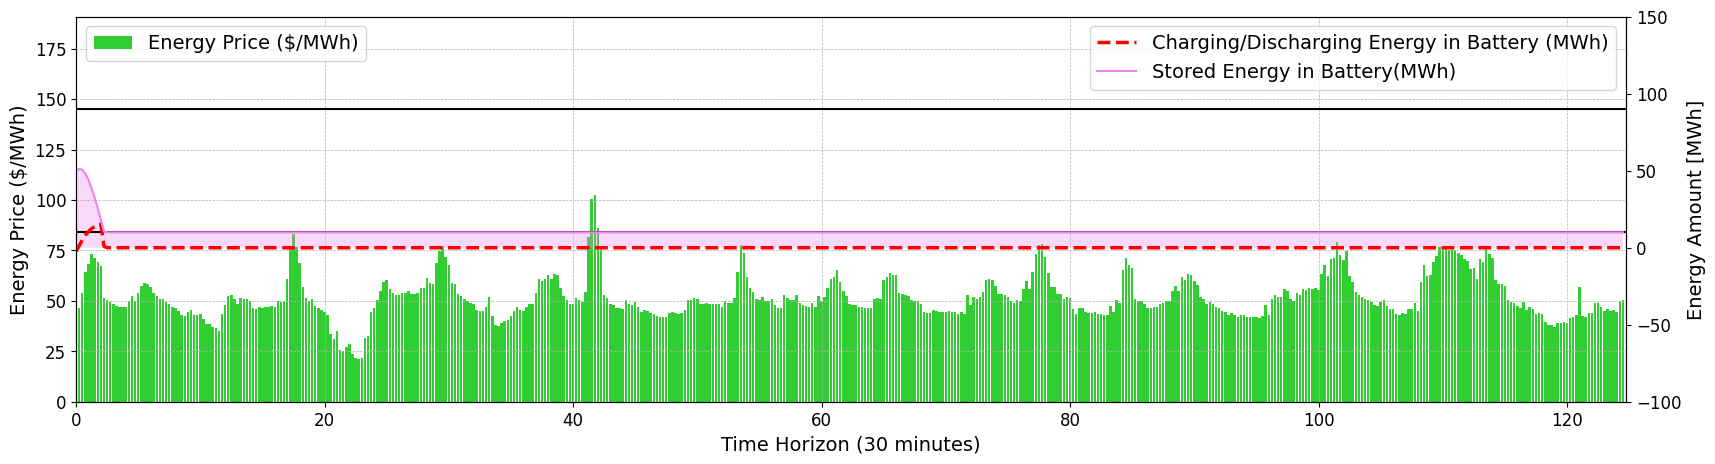

In [6]:
model1_test = LSTM()
model1_test.load_state_dict(torch.load('MODEL1.pt'))
env_train = Env(0.0, price_train)
env_val   = Env(0.0, price_val)
env_test  = Env(0.0, price_test)
bat_val = []; bat_test = []
cha_val = []; cha_test = []
dis_val = []; dis_test = []
deg_val = []; deg_test = []
rev_val = []; rev_test = []
imb_test = []; con_test = []

state = env_val.reset()
history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
for k in range(len(env_val.data_imb)-1):
    pi_out, next_history = model1_test.pi(torch.tensor(state[-1], dtype=torch.float), history)
    action = pi_out[0].tolist()
    next_state, reward, done, info = env_val.step(action)

    state = next_state[:]
    history = next_history

    bat = info[0]; cha = info[1]; dis = info[2]; deg = info[3]; revenue = info[4]
    bat_val += [bat]
    cha_val += [cha]
    dis_val += [dis]
    deg_val += [deg]
    rev_val += [revenue]

state = env_test.reset()
history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
for l in range(len(env_test.data_imb)-1):
    pi_out, next_history = model1_test.pi(torch.tensor(state[-1], dtype=torch.float), history)
    action = pi_out[0].tolist()
    next_state, reward, done, info = env_test.step(action)

    state = next_state[:]
    history = next_history

    bat = info[0]; cha = info[1]; dis = info[2]; deg = info[3]; revenue = info[4]; imb = info[5]; con = info[6]
    bat_test += [bat]
    cha_test += [cha]
    dis_test += [dis]
    deg_test += [deg]
    rev_test += [revenue]
    imb_test += [imb]
    con_test += [con]

CHA_val   = round(max_price*100*np.mean(cha_val),3)
DIS_val   = round(max_price*100*np.mean(dis_val),3)
DEG_val   = round(max_price*100*np.mean(deg_val),3)
REV_val   = round(max_price*100*np.mean(rev_val),3)
CHA_test  = round(max_price*100*np.mean(cha_test),3)
DIS_test  = round(max_price*100*np.mean(dis_test),3)
DEG_test  = round(max_price*100*np.mean(deg_test),3)
REV_test  = round(max_price*100*np.mean(rev_test),3)
print("CHA_val: ${}".format(CHA_val).ljust(20), end="")
print("DIS_val: ${}".format(DIS_val).ljust(20), end="")
print("DEG_val: ${}".format(DEG_val).ljust(20), end="")
print("REV_val: ${}".format(REV_val).ljust(20))
print("CHA_test: ${}".format(CHA_test).ljust(20), end="")
print("DIS_test: ${}".format(DIS_test).ljust(20), end="")
print("DEG_test: ${}".format(DEG_test).ljust(20), end="")
print("REV_test: ${}".format(REV_test).ljust(20))
print("------------------------------------------------------------------------------------------")

eg_len = len(bat_test)
fig_model1 = plt.figure(figsize=(20,5))
plt.bar(np.arange(eg_len)/4, max_price*np.array(imb_test), color='limegreen', width=0.2, label="Energy Price ($/MWh)")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Time Horizon (30 minutes)", fontsize=14)
plt.ylabel("Energy Price ($/MWh)", fontsize=14)
plt.xlim([0,eg_len/4])
plt.ylim([0,max_price])
plt.legend(fontsize=14, loc=2)
plt.grid(linestyle='--', linewidth=0.5)
plt.twinx()
plt.plot([100*soc_max for _ in range(eg_len)], 'k', linewidth=1.5)
plt.plot([100*soc_min for _ in range(eg_len)], 'k', linewidth=1.5)
plt.plot(np.arange(eg_len)/4, 100*np.array(con_test), 'r--', linewidth=2.5, label="Charging/Discharging Energy in Battery (MWh)")
plt.plot(np.arange(eg_len)/4, 100*np.array(bat_test), color='violet', label="Stored Energy in Battery(MWh)")
plt.fill_between(np.arange(eg_len)/4, 100*np.array(bat_test), 0, facecolor='violet', alpha=0.3)
plt.yticks(fontsize = 12)
plt.ylabel("Energy Amount [MWh]", fontsize=14)
plt.ylim([-100,150])
plt.legend(fontsize=14, loc=1)
plt.show()

con_test1 = con_test.copy()
rev_test1 = rev_test.copy()

<ipython-input-7-5bea21dd2bf4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2_test.load_state_dict(torch.load('MODEL2.pt'))


CHA_val: $69.414    DIS_val: $102.195   DEG_val: $2.746     REV_val: $30.035    
CHA_test: $56.449   DIS_test: $73.34    DEG_test: $2.322    REV_test: $14.569   
------------------------------------------------------------------------------------------


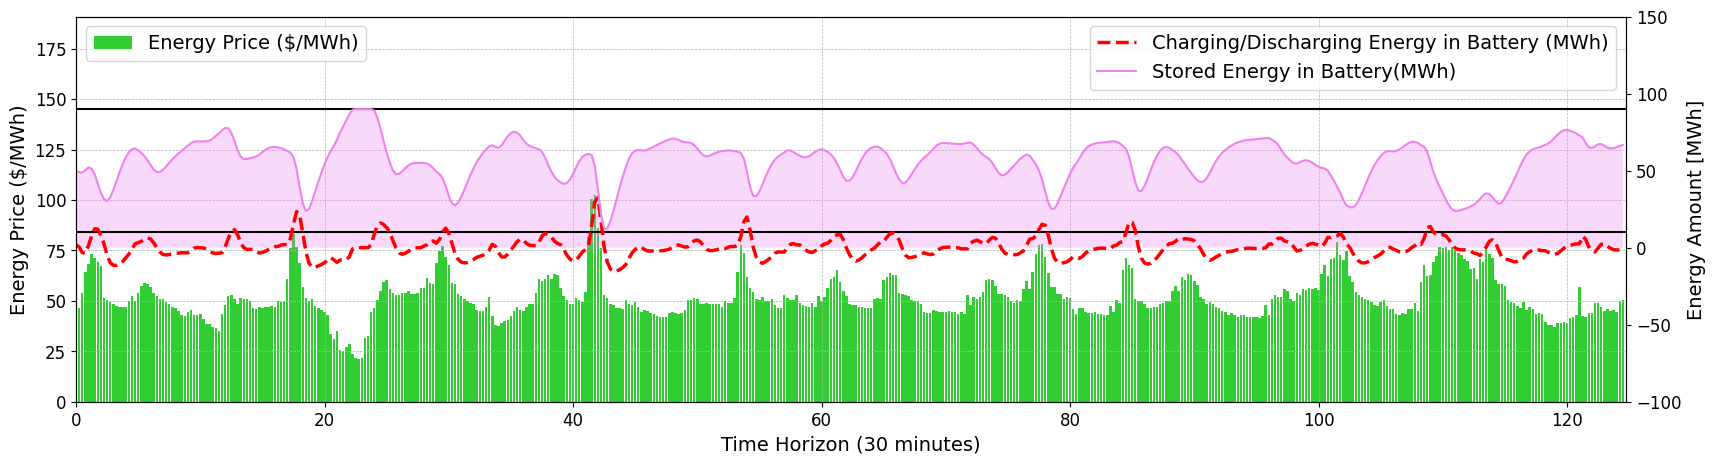

In [7]:
model2_test = LSTM()
model2_test.load_state_dict(torch.load('MODEL2.pt'))
env_train = Env(1.0, price_train)
env_val   = Env(1.0, price_val)
env_test  = Env(1.0, price_test)
bat_val = []; bat_test = []
cha_val = []; cha_test = []
dis_val = []; dis_test = []
deg_val = []; deg_test = []
rev_val = []; rev_test = []
imb_test = []; con_test = []

state = env_val.reset()
history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
for k in range(len(env_val.data_imb)-1):
    pi_out, next_history = model2_test.pi(torch.tensor(state[-1], dtype=torch.float), history)
    action = pi_out[0].tolist()
    next_state, reward, done, info = env_val.step(action)

    state = next_state[:]
    history = next_history

    bat = info[0]; cha = info[1]; dis = info[2]; deg = info[3]; revenue = info[4]
    bat_val += [bat]
    cha_val += [cha]
    dis_val += [dis]
    deg_val += [deg]
    rev_val += [revenue]

state = env_test.reset()
history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
for l in range(len(env_test.data_imb)-1):
    pi_out, next_history = model2_test.pi(torch.tensor(state[-1], dtype=torch.float), history)
    action = pi_out[0].tolist()
    next_state, reward, done, info = env_test.step(action)

    state = next_state[:]
    history = next_history

    bat = info[0]; cha = info[1]; dis = info[2]; deg = info[3]; revenue = info[4]; imb = info[5]; con = info[6]
    bat_test += [bat]
    cha_test += [cha]
    dis_test += [dis]
    deg_test += [deg]
    rev_test += [revenue]
    imb_test += [imb]
    con_test += [con]


CHA_val   = round(max_price*100*np.mean(cha_val),3)
DIS_val   = round(max_price*100*np.mean(dis_val),3)
DEG_val   = round(max_price*100*np.mean(deg_val),3)
REV_val   = round(max_price*100*np.mean(rev_val),3)
CHA_test  = round(max_price*100*np.mean(cha_test),3)
DIS_test  = round(max_price*100*np.mean(dis_test),3)
DEG_test  = round(max_price*100*np.mean(deg_test),3)
REV_test  = round(max_price*100*np.mean(rev_test),3)
print("CHA_val: ${}".format(CHA_val).ljust(20), end="")
print("DIS_val: ${}".format(DIS_val).ljust(20), end="")
print("DEG_val: ${}".format(DEG_val).ljust(20), end="")
print("REV_val: ${}".format(REV_val).ljust(20))
print("CHA_test: ${}".format(CHA_test).ljust(20), end="")
print("DIS_test: ${}".format(DIS_test).ljust(20), end="")
print("DEG_test: ${}".format(DEG_test).ljust(20), end="")
print("REV_test: ${}".format(REV_test).ljust(20))
print("------------------------------------------------------------------------------------------")

eg_len = len(bat_test)
fig_model2 = plt.figure(figsize=(20,5))
plt.bar(np.arange(eg_len)/4, max_price*np.array(imb_test), color='limegreen', width=0.2, label="Energy Price ($/MWh)")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Time Horizon (30 minutes)", fontsize=14)
plt.ylabel("Energy Price ($/MWh)", fontsize=14)
plt.xlim([0,eg_len/4])
plt.ylim([0,max_price])
plt.legend(fontsize=14, loc=2)
plt.grid(linestyle='--', linewidth=0.5)
plt.twinx()
plt.plot([100*soc_max for _ in range(eg_len)], 'k', linewidth=1.5)
plt.plot([100*soc_min for _ in range(eg_len)], 'k', linewidth=1.5)
plt.plot(np.arange(eg_len)/4, 100*np.array(con_test), 'r--', linewidth=2.5, label="Charging/Discharging Energy in Battery (MWh)")
plt.plot(np.arange(eg_len)/4, 100*np.array(bat_test), color='violet', label="Stored Energy in Battery(MWh)")
plt.fill_between(np.arange(eg_len)/4, 100*np.array(bat_test), 0, facecolor='violet', alpha=0.3)
plt.yticks(fontsize = 12)
plt.ylabel("Energy Amount [MWh]", fontsize=14)
plt.ylim([-100,150])
plt.legend(fontsize=14, loc=1)
plt.show()

con_test2 = con_test.copy()
rev_test2 = rev_test.copy()

<ipython-input-8-cb0e097162f0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model3_test.load_state_dict(torch.load('MODEL3.pt'))


CHA_val: $65.505    DIS_val: $107.889   DEG_val: $2.817     REV_val: $39.568    
CHA_test: $62.866   DIS_test: $88.461   DEG_test: $2.773    REV_test: $22.823   
------------------------------------------------------------------------------------------


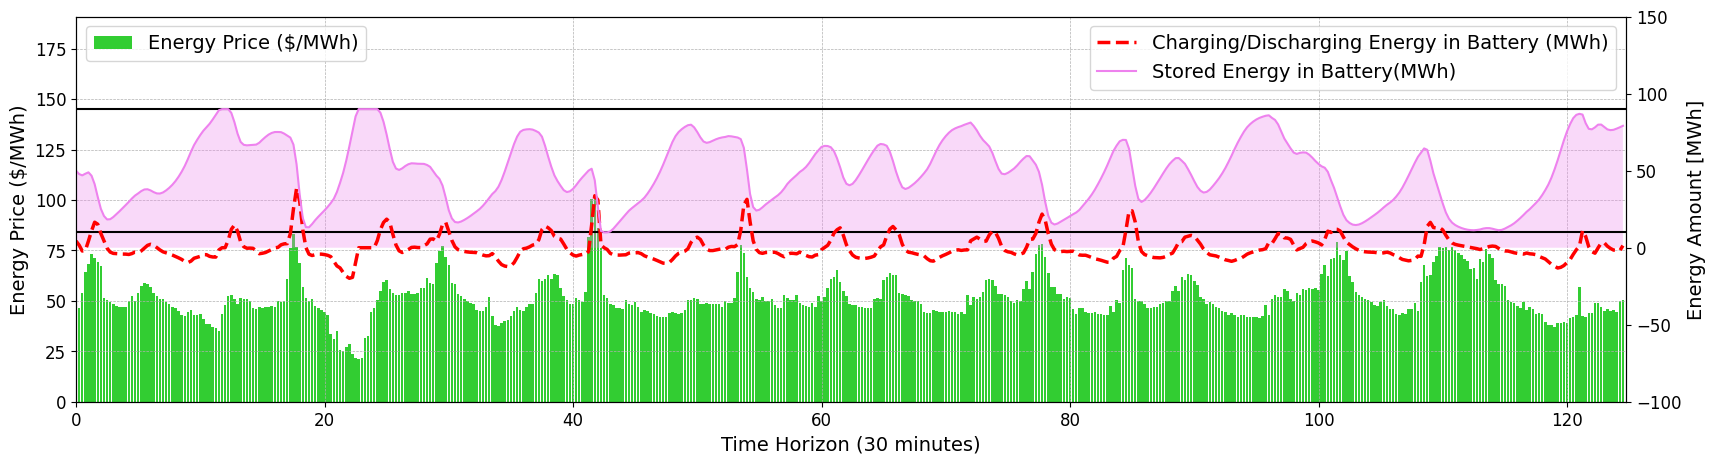

In [8]:
model3_test = LSTM()
model3_test.load_state_dict(torch.load('MODEL3.pt'))
env_train = Env(0.1, price_train)
env_val   = Env(0.1, price_val)
env_test  = Env(0.1, price_test)
bat_val = []; bat_test = []
cha_val = []; cha_test = []
dis_val = []; dis_test = []
deg_val = []; deg_test = []
rev_val = []; rev_test = []
imb_test = []; con_test = []

state = env_val.reset()
history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
for k in range(len(env_val.data_imb)-1):
    pi_out, next_history = model3_test.pi(torch.tensor(state[-1], dtype=torch.float), history)
    action = pi_out[0].tolist()
    next_state, reward, done, info = env_val.step(action)

    state = next_state[:]
    history = next_history

    bat = info[0]; cha = info[1]; dis = info[2]; deg = info[3]; revenue = info[4]
    bat_val += [bat]
    cha_val += [cha]
    dis_val += [dis]
    deg_val += [deg]
    rev_val += [revenue]

state = env_test.reset()
history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
for l in range(len(env_test.data_imb)-1):
    pi_out, next_history = model3_test.pi(torch.tensor(state[-1], dtype=torch.float), history)
    action = pi_out[0].tolist()
    next_state, reward, done, info = env_test.step(action)

    state = next_state[:]
    history = next_history

    bat = info[0]; cha = info[1]; dis = info[2]; deg = info[3]; revenue = info[4]; imb = info[5]; con = info[6]
    bat_test += [bat]
    cha_test += [cha]
    dis_test += [dis]
    deg_test += [deg]
    rev_test += [revenue]
    imb_test += [imb]
    con_test += [con]

CHA_val   = round(max_price*100*np.mean(cha_val),3)
DIS_val   = round(max_price*100*np.mean(dis_val),3)
DEG_val   = round(max_price*100*np.mean(deg_val),3)
REV_val   = round(max_price*100*np.mean(rev_val),3)
CHA_test  = round(max_price*100*np.mean(cha_test),3)
DIS_test  = round(max_price*100*np.mean(dis_test),3)
DEG_test  = round(max_price*100*np.mean(deg_test),3)
REV_test  = round(max_price*100*np.mean(rev_test),3)
print("CHA_val: ${}".format(CHA_val).ljust(20), end="")
print("DIS_val: ${}".format(DIS_val).ljust(20), end="")
print("DEG_val: ${}".format(DEG_val).ljust(20), end="")
print("REV_val: ${}".format(REV_val).ljust(20))
print("CHA_test: ${}".format(CHA_test).ljust(20), end="")
print("DIS_test: ${}".format(DIS_test).ljust(20), end="")
print("DEG_test: ${}".format(DEG_test).ljust(20), end="")
print("REV_test: ${}".format(REV_test).ljust(20))
print("------------------------------------------------------------------------------------------")

eg_len = len(bat_test)
fig_model3 = plt.figure(figsize=(20,5))
plt.bar(np.arange(eg_len)/4, max_price*np.array(imb_test), color='limegreen', width=0.2, label="Energy Price ($/MWh)")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Time Horizon (30 minutes)", fontsize=14)
plt.ylabel("Energy Price ($/MWh)", fontsize=14)
plt.xlim([0,eg_len/4])
plt.ylim([0,max_price])
plt.legend(fontsize=14, loc=2)
plt.grid(linestyle='--', linewidth=0.5)
plt.twinx()
plt.plot([100*soc_max for _ in range(eg_len)], 'k', linewidth=1.5)
plt.plot([100*soc_min for _ in range(eg_len)], 'k', linewidth=1.5)
plt.plot(np.arange(eg_len)/4, 100*np.array(con_test), 'r--', linewidth=2.5, label="Charging/Discharging Energy in Battery (MWh)")
plt.plot(np.arange(eg_len)/4, 100*np.array(bat_test), color='violet', label="Stored Energy in Battery(MWh)")
plt.fill_between(np.arange(eg_len)/4, 100*np.array(bat_test), 0, facecolor='violet', alpha=0.3)
plt.yticks(fontsize = 12)
plt.ylabel("Energy Amount [MWh]", fontsize=14)
plt.ylim([-100,150])
plt.legend(fontsize=14, loc=1)
plt.show()

con_test3 = con_test.copy()
rev_test3 = rev_test.copy()

<ipython-input-9-84ff3613bf67>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model4_test.load_state_dict(torch.load('MODEL4.pt'))


CHA_val: $79.448    DIS_val: $133.039   DEG_val: $3.295     REV_val: $50.295    
CHA_test: $62.048   DIS_test: $97.093   DEG_test: $2.652    REV_test: $32.392   
------------------------------------------------------------------------------------------


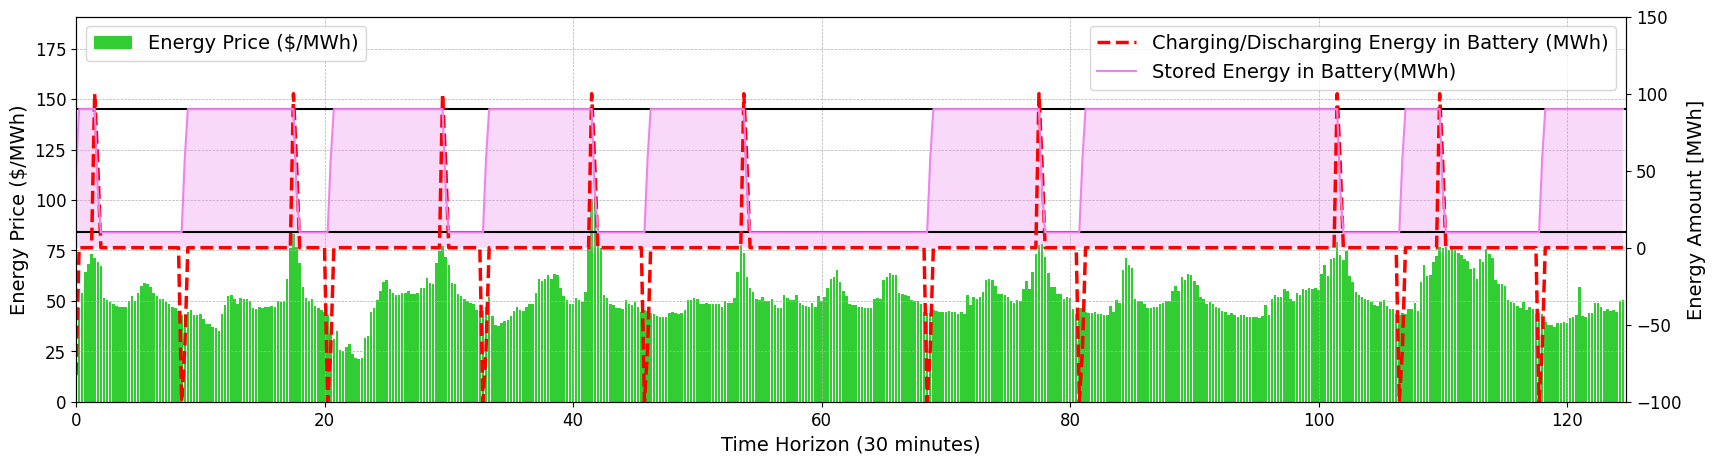

In [9]:
model4_test = LSTM2()
model4_test.load_state_dict(torch.load('MODEL4.pt'))
env_train = Env(0.0, price_train)
env_val   = Env(0.0, price_val)
env_test  = Env(0.0, price_test)
bat_val = []; bat_test = []
cha_val = []; cha_test = []
dis_val = []; dis_test = []
deg_val = []; deg_test = []
rev_val = []; rev_test = []
imb_test = []; con_test = []

state = env_val.reset()
history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
for k in range(len(env_val.data_imb)-1):
    action, next_history = model4_test.sample_action(torch.tensor(state[-1], dtype=torch.float), history, 0.0)
    if action==0: actionX=[-100000.0]
    if action==1: actionX=[0.0]
    if action==2: actionX=[100000.0]
    next_state, reward, done, info = env_val.step(actionX)

    state = next_state[:]
    history = next_history

    bat = info[0]; cha = info[1]; dis = info[2]; deg = info[3]; revenue = info[4]
    bat_val += [bat]
    cha_val += [cha]
    dis_val += [dis]
    deg_val += [deg]
    rev_val += [revenue]

state = env_test.reset()
history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
for l in range(len(env_test.data_imb)-1):
    action, next_history = model4_test.sample_action(torch.tensor(state[-1], dtype=torch.float), history, 0.0)
    if action==0: actionX=[-100000.0]
    if action==1: actionX=[0.0]
    if action==2: actionX=[100000.0]
    next_state, reward, done, info = env_test.step(actionX)

    state = next_state[:]
    history = next_history

    bat = info[0]; cha = info[1]; dis = info[2]; deg = info[3]; revenue = info[4]; imb = info[5]; con = info[6]
    bat_test += [bat]
    cha_test += [cha]
    dis_test += [dis]
    deg_test += [deg]
    rev_test += [revenue]
    imb_test += [imb]
    con_test += [con]

CHA_val   = round(max_price*100*np.mean(cha_val),3)
DIS_val   = round(max_price*100*np.mean(dis_val),3)
DEG_val   = round(max_price*100*np.mean(deg_val),3)
REV_val   = round(max_price*100*np.mean(rev_val),3)
CHA_test  = round(max_price*100*np.mean(cha_test),3)
DIS_test  = round(max_price*100*np.mean(dis_test),3)
DEG_test  = round(max_price*100*np.mean(deg_test),3)
REV_test  = round(max_price*100*np.mean(rev_test),3)
print("CHA_val: ${}".format(CHA_val).ljust(20), end="")
print("DIS_val: ${}".format(DIS_val).ljust(20), end="")
print("DEG_val: ${}".format(DEG_val).ljust(20), end="")
print("REV_val: ${}".format(REV_val).ljust(20))
print("CHA_test: ${}".format(CHA_test).ljust(20), end="")
print("DIS_test: ${}".format(DIS_test).ljust(20), end="")
print("DEG_test: ${}".format(DEG_test).ljust(20), end="")
print("REV_test: ${}".format(REV_test).ljust(20))
print("------------------------------------------------------------------------------------------")

eg_len = len(bat_test)
fig_model4 = plt.figure(figsize=(20,5))
plt.bar(np.arange(eg_len)/4, max_price*np.array(imb_test), color='limegreen', width=0.2, label="Energy Price ($/MWh)")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Time Horizon (30 minutes)", fontsize=14)
plt.ylabel("Energy Price ($/MWh)", fontsize=14)
plt.xlim([0,eg_len/4])
plt.ylim([0,max_price])
plt.legend(fontsize=14, loc=2)
plt.grid(linestyle='--', linewidth=0.5)
plt.twinx()
plt.plot([100*soc_max for _ in range(eg_len)], 'k', linewidth=1.5)
plt.plot([100*soc_min for _ in range(eg_len)], 'k', linewidth=1.5)
plt.plot(np.arange(eg_len)/4, 100*np.array(con_test), 'r--', linewidth=2.5, label="Charging/Discharging Energy in Battery (MWh)")
plt.plot(np.arange(eg_len)/4, 100*np.array(bat_test), color='violet', label="Stored Energy in Battery(MWh)")
plt.fill_between(np.arange(eg_len)/4, 100*np.array(bat_test), 0, facecolor='violet', alpha=0.3)
plt.yticks(fontsize = 12)
plt.ylabel("Energy Amount [MWh]", fontsize=14)
plt.ylim([-100,150])
plt.legend(fontsize=14, loc=1)
plt.show()

con_test4 = con_test.copy()
rev_test4 = rev_test.copy()

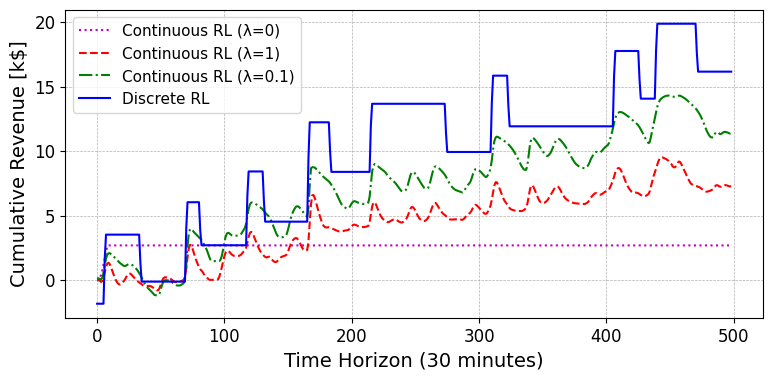

In [10]:
cumulative_rev_test1 = []
cumulative_rev_test2 = []
cumulative_rev_test3 = []
cumulative_rev_test4 = []

total1 = 0; total2 = 0; total3 = 0; total4 = 0
for i in range(len(rev_test1)):
    total1 += rev_test1[i]
    cumulative_rev_test1.append(total1)
    total2 += rev_test2[i]
    cumulative_rev_test2.append(total2)
    total3 += rev_test3[i]
    cumulative_rev_test3.append(total3)
    total4 += rev_test4[i]
    cumulative_rev_test4.append(total4)

fig_rev = plt.figure(figsize=(9,4))
plt.plot(max_price*0.1*np.array(cumulative_rev_test1), "m:", label="Continuous RL (λ=0)")
plt.plot(max_price*0.1*np.array(cumulative_rev_test2), "r--", label="Continuous RL (λ=1)")
plt.plot(max_price*0.1*np.array(cumulative_rev_test3), "g-.", label="Continuous RL (λ=0.1)")
plt.plot(max_price*0.1*np.array(cumulative_rev_test4), "b", label="Discrete RL")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Time Horizon (30 minutes)", fontsize=14)
plt.ylabel("Cumulative Revenue [k$]", fontsize=14)
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize=11, loc=2)
plt.show()

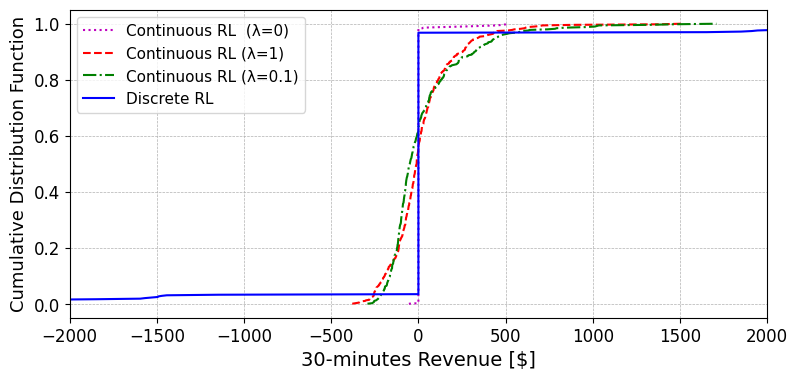

In [11]:
cdf_rev_test1 = np.arange(1, len(rev_test1)+1) / len(rev_test1)
cdf_rev_test2 = np.arange(1, len(rev_test2)+1) / len(rev_test2)
cdf_rev_test3 = np.arange(1, len(rev_test3)+1) / len(rev_test3)
cdf_rev_test4 = np.arange(1, len(rev_test4)+1) / len(rev_test4)

fig_cdf = plt.figure(figsize=(9,4))
plt.plot(np.sort(max_price*100*np.array(rev_test1)), cdf_rev_test1, "m:", label="Continuous RL  (λ=0)")
plt.plot(np.sort(max_price*100*np.array(rev_test2)), cdf_rev_test2, "r--", label="Continuous RL (λ=1)")
plt.plot(np.sort(max_price*100*np.array(rev_test3)), cdf_rev_test3, "g-.", label="Continuous RL (λ=0.1)")
plt.plot(np.sort(max_price*100*np.array(rev_test4)), cdf_rev_test4, "b", label="Discrete RL")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("30-minutes Revenue [$]", fontsize=14)
plt.ylabel("Cumulative Distribution Function", fontsize=13)
plt.xlim([-2000,2000])
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize=11, loc=2)
plt.show()

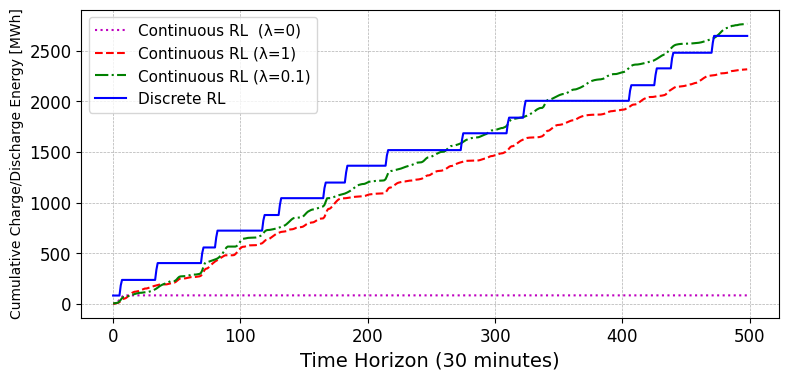

In [12]:
cumulative_con_test1 = []
cumulative_con_test2 = []
cumulative_con_test3 = []
cumulative_con_test4 = []

total1 = 0; total2 = 0; total3 = 0; total4 = 0
for i in range(len(con_test1)):
    total1 += abs(con_test1[i])
    cumulative_con_test1.append(total1)
    total2 += abs(con_test2[i])
    cumulative_con_test2.append(total2)
    total3 += abs(con_test3[i])
    cumulative_con_test3.append(total3)
    total4 += abs(con_test4[i])
    cumulative_con_test4.append(total4)

fig_con = plt.figure(figsize=(9,4))
plt.plot(100*np.array(cumulative_con_test1), "m:", label="Continuous RL  (λ=0)")
plt.plot(100*np.array(cumulative_con_test2), "r--", label="Continuous RL (λ=1)")
plt.plot(100*np.array(cumulative_con_test3), "g-.", label="Continuous RL (λ=0.1)")
plt.plot(100*np.array(cumulative_con_test4), "b", label="Discrete RL")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Time Horizon (30 minutes)", fontsize=14)
plt.ylabel("Cumulative Charge/Discharge Energy [MWh]", fontsize=10)
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize=11, loc=2)
plt.show()